# Classificació d'imatges amb CNN

En aquest notebook, es mostra com classificar imatges amb una xarxa neuronal convolucional (CNN). Veurem també quin seria el rendiment d'una xarxa neuronal feedforward (FNN) en aquest mateix problema.

## Instal·lació de l'entorn

En primer lloc, instal·lem les llibreries necessàries per a executar el codi. En el nostre cas, necessitarem `keras`.

In [15]:
%pip install --upgrade torch torchvision  datasets scikit-learn transformers matplotlib


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Ara importarem les llibreries necessàries per a fer classificació d'imatges utilitzant xarxes neuronals feed forward.

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import datasets

from PIL import Image

/home/carles/Documentos/notebooks/.venv/lib64/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Utilitzarem pytorch per a construir la xarxa neuronal i per a carregar el conjunt de dades.

## Preparem les dades

Com ja sabem, el rendiment de les xarxes neuronals _Feed Forward_ (FNN) en tasques de classificació d'imatges no és gaire bo. Això és degut a que les xarxes FNN no són capaces de capturar les relacions espacials entre els píxels de la imatge. Així i tot, començarem amb una xarxa FNN per a veure quin és el rendiment que podem obtenir.

Com a _DataSet_, utilitzarem el conjunt de dades `cats_vs_dogs` que obtindrem a continuació. Aquest conjunt de dades conté 25.000 imatges en color de 224x224 píxels, amb 2 classes diferents: 'Cat' i 'Dog'.

Son petites, però suficients per a mostrar com funcionen les xarxes neuronals en tasques de classificació d'imatges.

Utilitzarem `datasets` per a carregar el conjunt de dades i `DataLoader` per a carregar les dades en lots.

In [69]:
dataset = datasets.load_dataset('microsoft/cats_vs_dogs')

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

Partim el dataset en dos parts, una per entrenar el model i una altra per avaluar-lo.

In [75]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

Vejam que les classes s'ha aplicat i algunes de les imatges.

In [ ]:
print(dataset['train'][0])

print(dataset['train'].features)

classes = dataset['train'].features["labels"].names
classes

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x240 at 0x7F0A868B8FD0>, 'labels': 0}
{'image': Image(mode=None, decode=True, id=None), 'labels': ClassLabel(names=['cat', 'dog'], id=None)}


['cat', 'dog']

In [77]:
ds_train = dataset['train']
ds_test = dataset['test']

Mostrem algunes imatges del conjunt de dades.

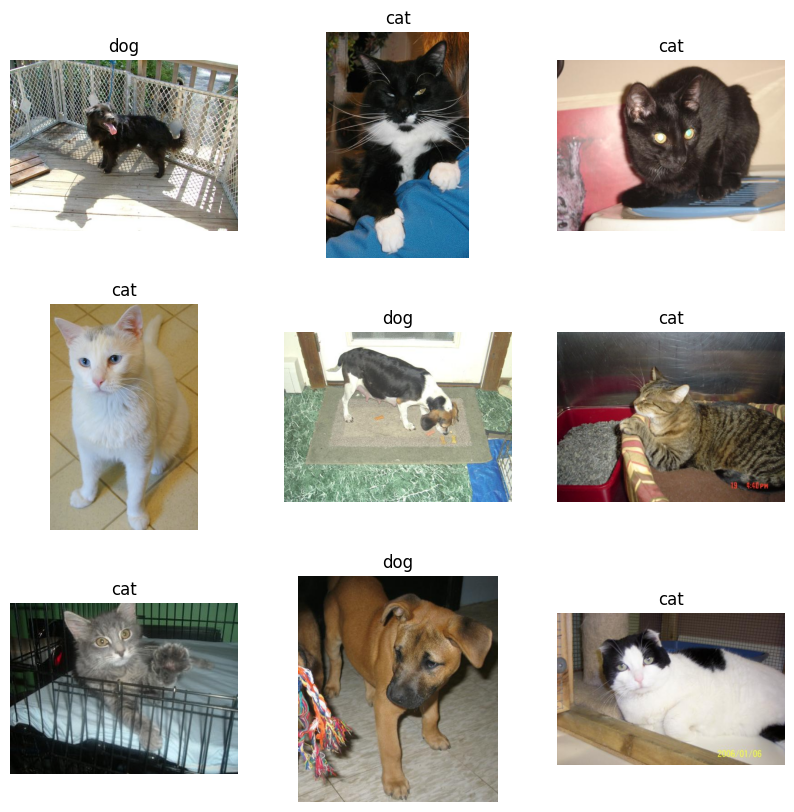

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Mostrem 3x3 imatges de gats i gossos
# Les imatges estan en format PIL

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    random_index = np.random.randint(0, len(ds_train))
    # mostrem el tamany de la imatge
    image = ds_train[random_index]['image']
    label = ds_train[random_index]['labels']
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(classes[label])

plt.show()

Les imatges tenen diferents dimensions, però les xarxes neuronals necessiten que totes les imatges tinguin les mateixes dimensions. Per això, redimensionarem les imatges a 128x128 píxels. Utilitzarem una transformació de `torchvision.transforms` per a fer-ho.

/home/carles/Documentos/notebooks/.venv/lib64/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


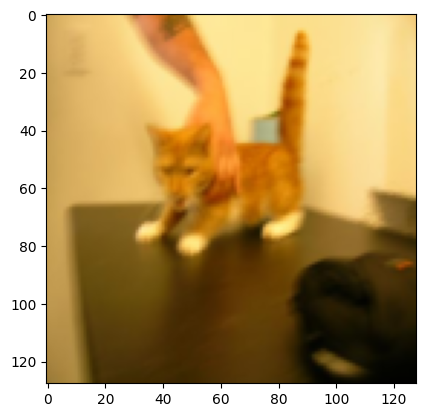

In [6]:
from torchvision.transforms import v2
transforms = v2.Compose([
    # Convertim a RGB
    v2.Lambda(lambda x: x.convert('RGB')),
    # Convertim la imatge a tensor, només necessari si tenim una imatge PIL
    v2.ToImage(),
    # opcional, la majoria d'imatges ja són uint8 en aquest punt
    v2.ToDtype(torch.float32, scale=True),
    # Redimensionem la imatge a 128x128
    v2.Resize(size=(128, 128), antialias=True),
    # Convertim la imatge a tensor, en valors de 0 a 1
    v2.ToTensor(),
])

# Apliquem les transformacions a la primera imatge
image = dataset['train'][0]['image']
image = transforms(image)

# Per mostrar la imatge, hem de transposar les dimensions (C, H, W) -> (H, W, C)
plt.imshow(image.permute(1, 2, 0))
plt.show()

Finalment crearem els `loaders` per a carregar les dades en lots, aplicant les transformacions necessàries.

In [80]:
# Creem un DataLoader per carregar les imatges

from torch.utils.data import DataLoader

# La funció collate_fn ens permet processar les dades abans de passar-les a la xarxa
# En aquest cas, convertim les imatges a tensors i les etiquetes a tensors de PyTorch
def collate_fn(batch):
    images = [transforms(x['image']) for x in batch]
    labels = [x['labels'] for x in batch]

    tensor_images = torch.stack(images)
    tensor_labels = torch.tensor(labels)

    return tensor_images, tensor_labels

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ds_test, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Xarxes neuronals feed forward

### Creem el model

Ara crearem el model de xarxa neuronal. Començarem amb una xarxa feed forward. Aquesta xarxa tindrà una capa d'entrada, dues capes ocultes i una capa de sortida.

La capa d'entrada tindrà 128x128x3 = 49152 neurones, ja que les imatges redimensionades tenen 128x128 píxels i 3 canals (RGB).

Per triar les dimensions de les capes ocultes, hem de tenir en compte que les imatges són petites i que volem que el model sigui lleuger. Així i tot, volem que el model sigui prou gran com per a capturar les relacions espacials entre els píxels de les imatges. Per això, triarem dues capes ocultes amb 1024 i 512 neurones, respectivament.

La capa de sortida tindrà 2 neurones, ja que hi ha 2 classes diferents. Utilitzarem la funció d'activació `softmax` per a obtenir les probabilitats de pertànyer a cada classe.

In [21]:
model = nn.Sequential( # Sequential ens permet definir una xarxa neuronal com una sequencia de capes
    # Rescalem les dades d'entrada a l'interval [0, 1]. Aixó facilita l'entrenament de la xarxa
    # Transformem les dades d'entrada a un vector unidimensional
    nn.Flatten(),
    # Capa oculta amb 1024 neurones i funció d'activació relu.
    nn.Linear(128 * 128 * 3, 1024),
    nn.ReLU(),
    # Capa oculta amb 512 neurones i funció d'activació relu.
    nn.Linear(1024, 512),
    nn.ReLU(),
    # Capa de sortida amb 1 neurona i funció d'activació sigmoide.
    nn.Linear(512, 1),
    nn.Sigmoid()
)


Ara entrenarem el model. Per a fer-ho, primer hem de compilar-lo. Utilitzarem l'optimitzador `adam` i la funció de pèrdua `binary_crossentropy`. A més, monitoritzarem l'exactitud del model durant l'entrenament.

Un cop compilat el model, l'entrenarem durant 10 èpoques. Utilitzarem un lot de 128 imatges (batch size).

In [9]:
# Volem utilitzar la GPU si està disponible

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Movem el model a la GPU. 
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=49152, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=1, bias=True)
  (6): Sigmoid()
)

In [111]:
def train(model, train_loader, num_epochs = 5):
    # Definim la funció de pèrdua i l'optimitzador
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    history = {
        'loss': [],
        'accuracy': []
    }

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            # Accuracy
            # Per calcular l'accuracy, comparem la sortida de la xarxa amb les etiquetes
            # i calculem el percentatge de prediccions correctes.
            # Hem de fer unsquezze a les etiquetes perquè tinguin la mateixa forma que les prediccions
            # (un tensor de 1 dimensió amb la mateixa longitud que les prediccions)
            accuracy = ((outputs > 0.5) == labels.unsqueeze(1)).float().mean()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
                print(f'Accuracy: {accuracy.item()}')
        
                history['loss'].append(loss.item())
                history['accuracy'].append(accuracy.item())

    return history

def validate(model, loader):
    model.eval()
    criterion = nn.BCELoss()
    history = {
        'loss': [],
        'accuracy': []
    }

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            accuracy = ((outputs > 0.5) == labels.unsqueeze(1)).float().mean()

            history['loss'].append(loss.item())
            history['accuracy'].append(accuracy.item())
    
    print(f'Validation Loss: {np.mean(history["loss"])}')
    print(f'Validation Accuracy: {np.mean(history["accuracy"])}')

    return history

In [84]:
history = train(model, train_loader)
print('Finished Training')

KeyboardInterrupt: 

Com podem veure, no hem aconsseguit gran cosa, ja que el `val_accuracy` apenes passa del 50% (tenient dues classes és equivalent al que tindriem triant a cegues).

Graficarem les dades de l'entrenament per veure-ho més clar.

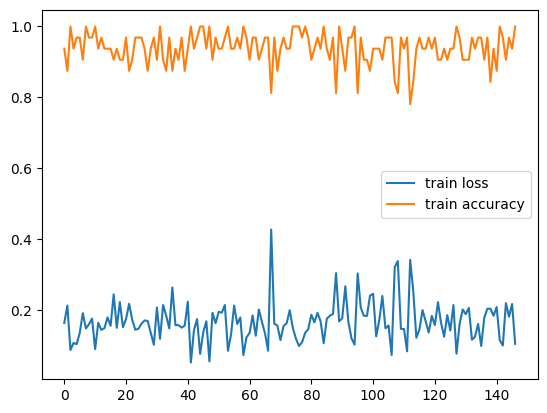

In [85]:
plt.plot(history["loss"], label="train loss")
accuracies = np.array(history["accuracy"])
plt.plot(accuracies, label="train accuracy")    
plt.legend()
plt.show()

Podem veure com, en cap moment hem pogut començar a millorar en les nostres prediccions.

Les xarxes neuronals feed forward no són capaces de capturar les relacions espacials entre els píxels de les imatges. Això fa que siguin molt fàcils de sobreajustar, com hem vist. HAurem de provar amb una xarxa neuronal convolucional (CNN) per a veure si podem millorar el rendiment.

## Xarxes neuronals convolucionals (CNN)

De cara a la pràctica, la diferència més gran en la construcció de la xarxa neuronal és que afegirem capes convolucionals i de _pooling_.

Les capes convolucionals són capaces de capturar les relacions espacials entre els píxels de la imatge. Això és el que fa que les CNN siguin molt més eficients que les FNN en tasques de classificació d'imatges.

Les capes de _pooling_ són capaces de reduir la mida de les imatges, mantenint-ne les característiques més importants. Això baixa el nombre de paràmetres de la xarxa i fa que sigui més lleugera.

A més, afegirem capes de _dropout_ per a reduir l'overfitting.

### Creem el model

Ara crearem el model de xarxa neuronal convolucional. Aquesta xarxa tindrà una capa d'entrada, una capa convolucional, una capa densa i una capa de sortida.

A continuació l'entrenarem i veurem com es comporta.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir el modelo en PyTorch
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5),  # Sin padding por defecto
    nn.ReLU(),

    # Aplanado
    nn.Flatten(),

    # Capa densa final
    # Se debe calcular correctamente la dimensión de entrada
    # LA fórmula es: W - F + 2P
    # W: tamaño de la imagen
    # F: tamaño del filtro
    # P: padding
    # S: stride
    # En este caso, la imagen de entrada es de 128x128
    # El tamaño del filtro es 5
    # No hay padding
    # La dimensión de entrada es 9 * 124 * 124
    nn.Linear(9 * 124 * 124, 1),  
    nn.Sigmoid()
)

print(model)


Sequential(
  (0): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=138384, out_features=1, bias=True)
  (4): Sigmoid()
)


In [88]:
history = train(model, train_loader)
print('Finished Training')

Epoch [1/5], Step [100/586], Loss: 0.6744709014892578
Accuracy: 0.625
Epoch [1/5], Step [200/586], Loss: 0.6914561986923218
Accuracy: 0.71875
Epoch [1/5], Step [300/586], Loss: 0.7264866828918457
Accuracy: 0.53125
Epoch [1/5], Step [400/586], Loss: 0.6395062208175659
Accuracy: 0.59375
Epoch [1/5], Step [500/586], Loss: 0.6024108529090881
Accuracy: 0.6875
Epoch [2/5], Step [100/586], Loss: 0.6413124799728394
Accuracy: 0.625
Epoch [2/5], Step [200/586], Loss: 0.7661932706832886
Accuracy: 0.5625
Epoch [2/5], Step [300/586], Loss: 0.7254787683486938
Accuracy: 0.59375
Epoch [2/5], Step [400/586], Loss: 0.5004631876945496
Accuracy: 0.71875
Epoch [2/5], Step [500/586], Loss: 0.6424636244773865
Accuracy: 0.625
Epoch [3/5], Step [100/586], Loss: 0.5969814658164978
Accuracy: 0.625
Epoch [3/5], Step [200/586], Loss: 0.5551609992980957
Accuracy: 0.78125
Epoch [3/5], Step [300/586], Loss: 0.5651085376739502
Accuracy: 0.6875
Epoch [3/5], Step [400/586], Loss: 0.4240415096282959
Accuracy: 0.8125
Epoc

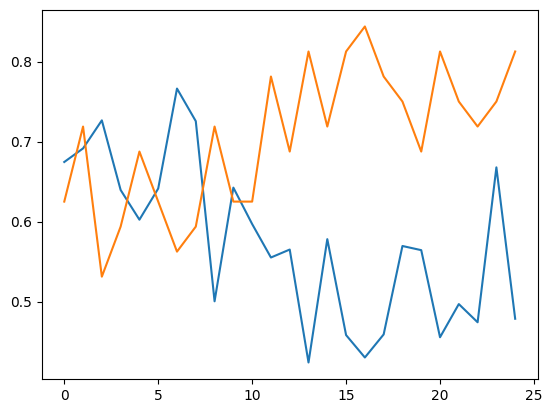

In [90]:
plt.plot(history["loss"], label="train loss")
accuracies = np.array(history["accuracy"])
plt.plot(accuracies, label="train accuracy")

In [91]:
history = validate(model, val_loader)
print('Finished Training')

Validation Loss: 0.6863837996307685
Validation Accuracy: 0.6409863947200126
Finished Training


Podem veure com solament amb una capa convolucional i una capa densa el resultat ja es prou millor que amb la xarxa feed forward. Es obvi com ja es comencen a identificar patrons que identifiquen a gossos i gats, encara que podriem millorar el rendiment de la xarxa, especialment en la validació.

Això és degut a que la xarxa és molt petita. Haurem d'apilar més capes convolucionals i de _pooling_ per a millorar el rendiment.

La primera capa convolucional capta patrons bàsics com línies i corbes. Si agreguem més capes convolucionals, aquestes podran capturar patrons més complexos com formes `bàsiques` i, finalment, l'objecte que volem classificar. També augmentarem el nombre de `filters` conforme anem afegint capes convolucionals, ja que conforme els patrons es compliquen hi haurà més possible combinacions de característiques interessants que caldrà capturar.

Per facilitar aquest procés, utilitzarem una tècnica molt útil: reduir el tamany espacial de les imatges. Si hem detectat que en una finestra de `3x3` hi ha una característica important, no ens importa si aquesta característica està en la part superior o inferior de la imatge. Així que podem reduir la mida de la imatge a la meitat. Això és el que fa la capa de _pooling_.

Hi ha dos tipus de _pooling_: _max pooling_ i _average pooling_. El _max pooling_ agafa el valor màxim de la finestra i l'_average pooling_ en fa la mitjana. En general, el _max pooling_ funciona millor que l'_average pooling_.

L'estructura bàsica serà la de capa convolucional, capa de _pooling_ i capa de _dropout_. La capa de _dropout_ és molt útil per a reduir l'overfitting.

Vejam com es comporta la xarxa amb aquesta nova estructura.

In [97]:
model = nn.Sequential(    
    # Capa Conv1
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=2),  # 'same' padding = 2
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Capa Conv2
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Capa Conv3
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Aplanado y capa de salida
    nn.Flatten(),

    # 10240 = 40 * 16 * 16 (tamaño de la imagen después de 3 capas de pooling)
    nn.Linear(10240, 1),  # Ajustar si el tamaño de entrada cambia
    nn.Sigmoid()
)
model


Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=10240, out_features=1, bias=True)
  (14): Sigmoid()
)

In [99]:
history = train(model, train_loader)
print('Finished Training')

Epoch [1/5], Step [100/586], Loss: 0.6835678219795227
Accuracy: 0.5


KeyboardInterrupt: 

In [98]:
history = validate(model, val_loader)
print('Finished Training')

Validation Loss: 0.6930385483365481
Validation Accuracy: 0.5088435374960607
Finished Training


Com podem veure, el rendiment de la xarxa no ha millorat massa. hauriem pde seguir afegint capes convolucionals i de _pooling_ per a millorar el rendiment.

De tota manera anem a veure una altra técnica: _data augmentation_ aplicarem una série de filtres a les imatges (escalats i rotacions) per dversificar les dades d'entrada i, per tant ajudar a la xarxa a generalitzar-se.

En pytorch podem fer-ho fàcilment amb `torchvision.transforms`, que ja hem utilitzat per a redimensionar les imatges.

Ho podeu executar per veure el resultat. Es possible, però, que necessite més de 10 époques per convergir.

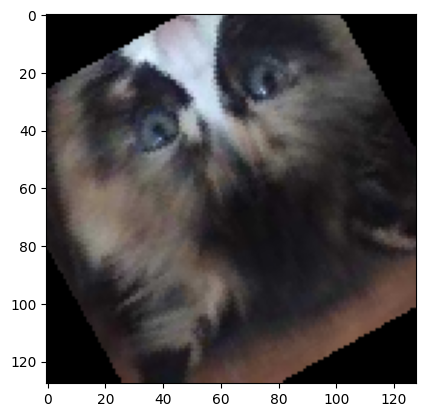

In [ ]:
from torchvision.transforms import v2
transforms = v2.Compose([
    # Convertim a RGB
    v2.Lambda(lambda x: x.convert('RGB')),
    # Convertim la imatge a tensor, només necessari si tenim una imatge PIL
    v2.ToImage(),
    # opcional, la majoria d'imatges ja són uint8 en aquest punt
    v2.ToDtype(torch.float32, scale=True),
    # Redimensionem la imatge a 128x128
    v2.RandomResizedCrop(size=(128, 128), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=30),
    # Convertim la imatge a tensor, en valors de 0 a 1
    v2.ToTensor(),
])

# Apliquem les transformacions a la primera imatge
image = dataset['train'][0]['image']
image = transforms(image)

# Per mostrar la imatge, hem de transposar les dimensions (C, H, W) -> (H, W, C)
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [114]:
# Creem un DataLoader per carregar les imatges

augmented_train_loader = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=collate_fn)

history = train(model, augmented_train_loader, num_epochs=10)

KeyboardInterrupt: 

## Xarxes neuronals convolucionals (CNN) pre-entrenades

Com haurem vist, entrenar una xarxa neuronal convolucional des de zero és una tasca molt costosa. Això és degut a que les xarxes neuronals convolucionals tenen molts paràmetres i entrenar-les requereix moltes dades i temps.

Afortunadament, podem utilitzar xarxes neuronals convolucionals pre-entrenades. Això ens estalvia molt temps i recursos.

Veurem com afinar una xarxa neuronal convolucional pre-entrenada per a que classifique les nostres dades.



Com a exemple, utilitzarem la xarxa `VGG16` pre-entrenada. La xarxa `VGG16` és una xarxa neuronal convolucional molt coneguda i ha estat entrenada amb el conjunt de dades `ImageNet`, que conté més de 14 milions d'imatges i 1000 classes diferents. Està formada per 16 capes, d'aquí el nom. La xarxa `VGG16` és molt potent i ha demostrat ser molt eficient en tasques de classificació d'imatges.

In [112]:
from keras.applications import VGG16

model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),
    VGG16(include_top=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.layers[1].trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

2025-03-03 00:35:27.134465: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 00:35:27.293168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 00:35:27.293213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 00:35:27.303640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 00:35:27.324959: I tensorflow/core/platform/cpu_feature_guar

NameError: name 'Sequential' is not defined

El resultat ara és molt millor. Això és degut a que hem pogut utilitzar les característiques apreses per la xarxa pre-entrenada per a classificar les imatges.

El _transfer learning_ és molt útil quan no tenim moltes dades o quan no tenim molts recursos per a entrenar una xarxa neuronal convolucional des de zero.

## Utilització en OpenCV

Per a utilitzar la xarxa neuronal convolucional pre-entrenada en OpenCV hauriem de convertir la xarxa a un format que OpenCV pugui llegir. Això és una mica complicat, però es pot fer. De tota manera en aquesta secció veurem com cridar al model de Keras des de OpenCV.

In [ ]:
# En opencv carreguem una imatge, la classifiquem i la mostrem.

import cv2

def classify_image_opencv(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) # Carreguem la imatge amb opencv i la convertim a RGB

    img_class = img # Creem una còpia de la imatge per modificar-la
    img_class = cv2.resize(img_class, (224, 224)) # Redimensionem la imatge a 224x224
    img_class = np.expand_dims(img_class, axis=0) # Redimensionem la imatge afegint una dimensió extra per indicar el batch

    pred = model.predict(img_class) # Classifiquem la imatge amb el model

    # Modifiquem la imatge original per agregar la etiqueta en verd
    if pred[0][0] > 0.5:
        print("Cat")
        cv2.putText(img, "Cat", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        print("Dog")
        cv2.putText(img, "Dog", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    plt.imshow(img)

In [ ]:
classify_image_opencv('data/PetImages/Cat/1.jpg')

In [ ]:
classify_image_opencv('data/PetImages/Dog/1.jpg')